In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Step 1: Using K-means clustering to identify low-resistivity regions
# Step 2: Using DBSCAN to identify spatially separated low-resistivity regions

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from resistivity_functions import *

import pandas as pd
import seaborn as sns

import pickle

In [4]:
datafile = '../Data/rho.txt'

dataframe_original = pd.read_csv(datafile,skiprows=1,usecols=[1,2,3,4],names=['x','y','z','rho'])

In [5]:
dataframe = dataframe_original['rho']

In [6]:
dataframe_array = dataframe.to_numpy()

In [7]:
#Try DBSCAN instead of SOM
import numpy.ma as ma
masked_data = ma.masked_values(dataframe_array,-9999.0)

In [8]:
log_rho = np.log10(masked_data)
log_rho = log_rho.reshape(-1,1)

<ipython-input-8-7939f8e8710d>:1: RuntimeWarning: invalid value encountered in log10
  log_rho = np.log10(masked_data)


In [9]:
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters=2,random_state=1).fit(log_rho)
labels = clustering.labels_

In [10]:
num_clusters=np.max(labels)

In [11]:
dataframe_original['cluster_id'] = labels

In [12]:
dataframe_original.loc[dataframe_original.rho==-9999, 'cluster_id'] = -1

In [13]:
#Minimum resistivity in high-resistivity region
min(dataframe_original['rho'][dataframe_original['cluster_id']==0])

37.3

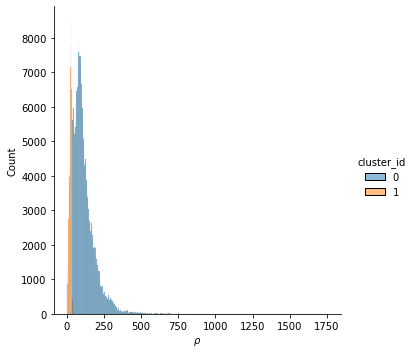

In [14]:
ax = sns.displot(dataframe_original[dataframe_original['rho']!=-9999], x='rho', hue='cluster_id')
ax.set_xlabels(r'$\rho$')

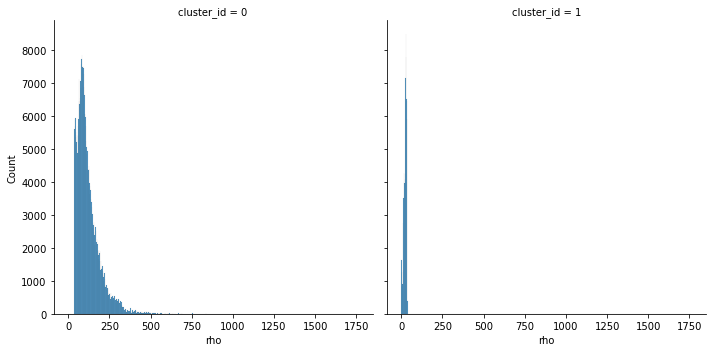

In [15]:
sns.displot(dataframe_original[dataframe_original['rho']!=-9999], x='rho', col='cluster_id')

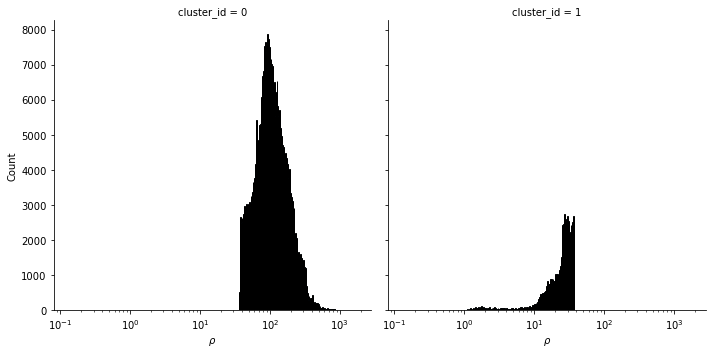

In [16]:
ax = sns.displot(dataframe_original[dataframe_original['rho']!=-9999], x='rho', col='cluster_id',log_scale=True)
ax.set_xlabels(r'$\rho$')

In [17]:
labels_rho = dataframe_original['cluster_id']

In [18]:
data = Data(dataframe=dataframe_original)

## K-Means clustering: Identifying low-resistivity and high-resistivity regions

### Value: z

In [19]:
data.display_cross_section(variable='z',quantity='cluster_id',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=-12.0, description='value', max=28.0, min=-50.0, step=2.0), Output()),…

### Value: x

In [20]:
data.display_cross_section(variable='x',quantity='cluster_id',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=243050.0, description='value', max=245400.0, min=240700.0, step=50.0),…

### Value: y

In [21]:
data.display_cross_section(variable='y',quantity='cluster_id',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=561250.0, description='value', max=565000.0, min=557500.0, step=50.0),…

In [22]:
data_cluster = labels_rho

In [23]:
low_resistivity_indices = np.where(data_cluster==1)

In [24]:
low_resistivity_indices = np.reshape(low_resistivity_indices,-1)

In [25]:
low_resistivity_indices = np.asarray(low_resistivity_indices)

In [26]:
list_low_resistivity_indices = low_resistivity_indices.tolist()

In [27]:
data_size = len(list_low_resistivity_indices)

In [28]:
dataframe_coordinates = dataframe_original[['x','y','z']]

In [29]:
dataframe = dataframe_coordinates.iloc[list_low_resistivity_indices]

In [30]:
data = Data(dataframe=dataframe)

In [31]:
data_array = data.dataframe_to_numpy_array()

In [32]:
normalized_data = data.normalize_data(data_array)

In [33]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(min_samples=20,eps=0.14).fit(normalized_data)
labels = clustering.labels_

In [34]:
data_cluster = labels + 1

In [35]:
data_cluster_resistivity_position = labels_rho.to_numpy()
data_cluster_resistivity_position[list_low_resistivity_indices] = data_cluster

In [36]:
num_clusters=np.max(data_cluster_resistivity_position)

In [37]:
dataframe_original['cluster_id_resistivity_position'] = data_cluster_resistivity_position
data = Data(dataframe=dataframe_original)

## DBSCAN: Identifying spatially separated low-resistivity regions

### Value: z

In [38]:
data.display_cross_section(variable='z',quantity='cluster_id_resistivity_position',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=-12.0, description='value', max=28.0, min=-50.0, step=2.0), Output()),…

### Value: x

In [39]:
data.display_cross_section(variable='x',quantity='cluster_id_resistivity_position',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=243050.0, description='value', max=245400.0, min=240700.0, step=50.0),…

### Value: y

In [40]:
data.display_cross_section(variable='y',quantity='cluster_id_resistivity_position',logscale=False, vmin=-1, vmax=num_clusters, cmap="cubehelix")

interactive(children=(FloatSlider(value=561250.0, description='value', max=565000.0, min=557500.0, step=50.0),…

In [41]:
df1 = dataframe_original[dataframe_original['rho']>0]
df = pd.DataFrame(df1,columns=['x','y','z','cluster_id_resistivity_position'])
df.rename(columns={'cluster_id_resistivity_position':'cluster'}, inplace=True)

In [42]:
df = pd.DataFrame(dataframe_original, columns=['x','y','z','cluster_id_resistivity_position'])
df.rename(columns={'cluster_id_resistivity_position':'cluster'}, inplace=True)

In [43]:
vmin = df['cluster'].min()
vmax = df['cluster'].max()

In [44]:
x_min = data.find_min('x')
y_min = data.find_min('y')
z_min = data.find_min('z')

In [45]:
x_step = data.find_step('x')
y_step = data.find_step('y')
z_step = data.find_step('z')

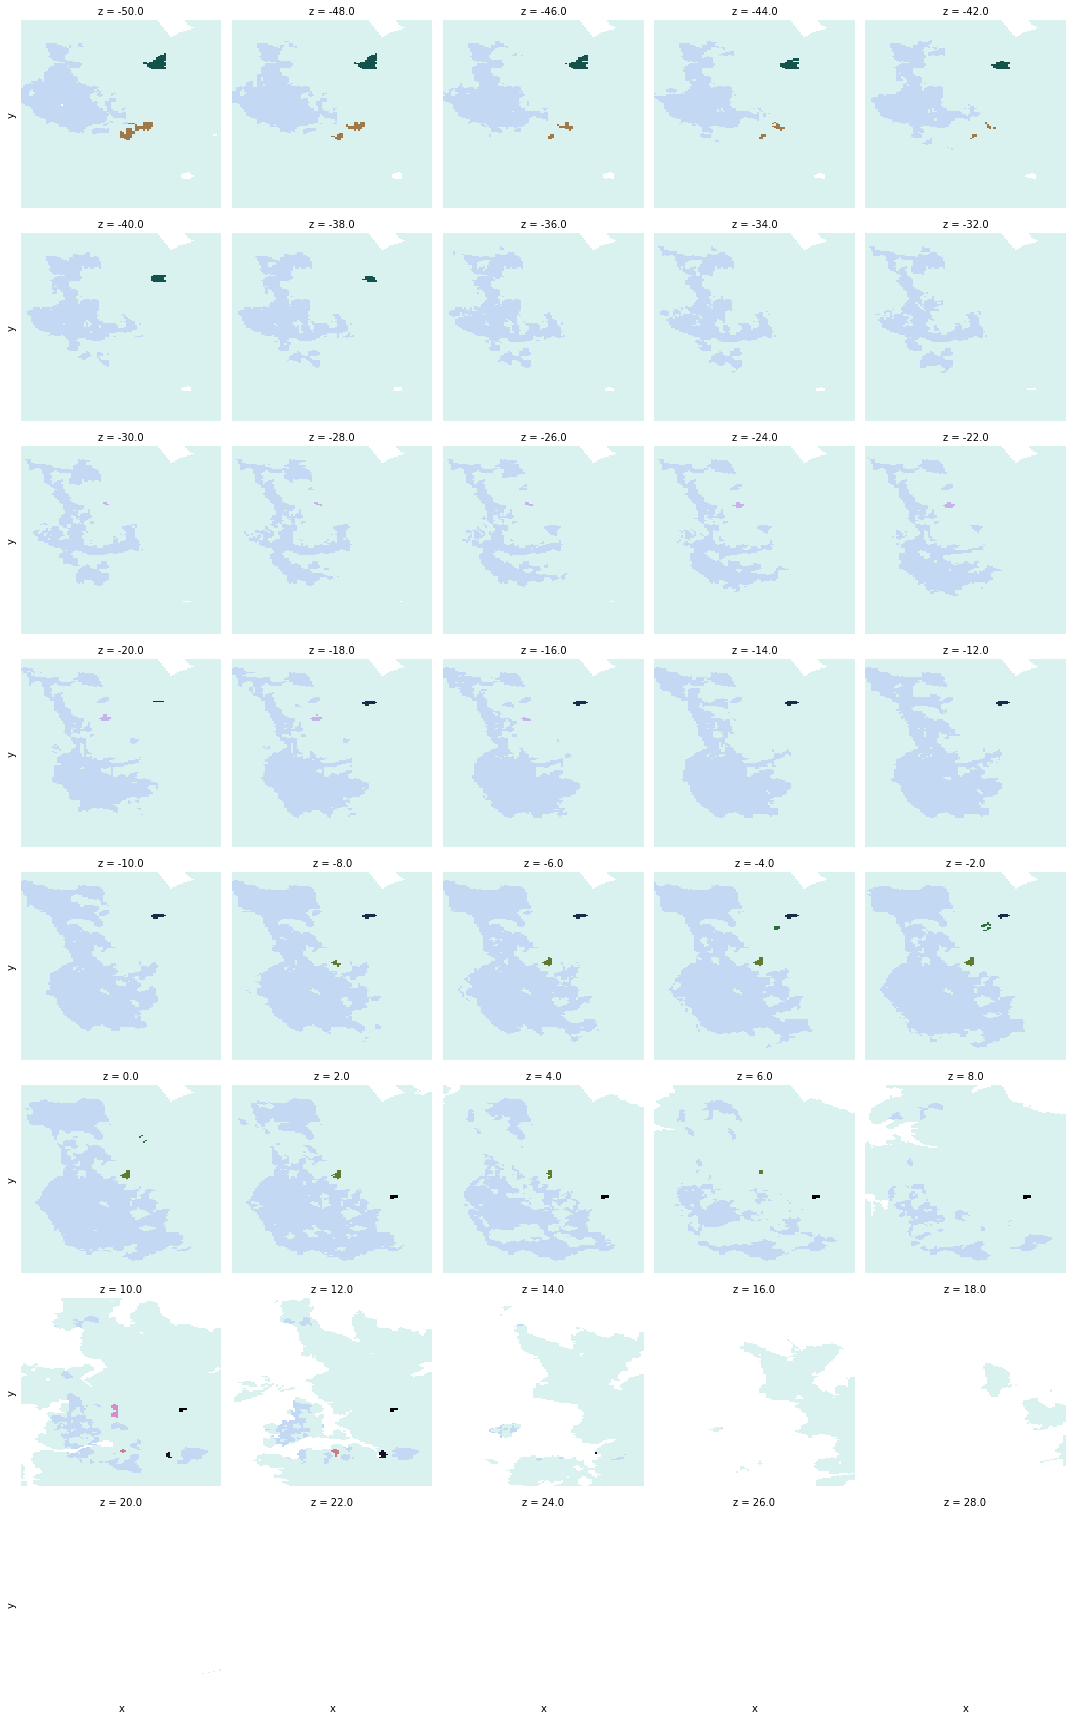

In [46]:
def draw_heatmap_z(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df, col='z',col_wrap=5)
fg.map_dataframe(draw_heatmap_z, 'x', 'y', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r', cbar=False)
fg.tight_layout()

In [47]:
#Want to display data in 7x5 grid, in accordance with A4 paper size
N = 35

In [48]:
df1 = df[df['x'].between(x_min, x_min + (N-1)*x_step)]

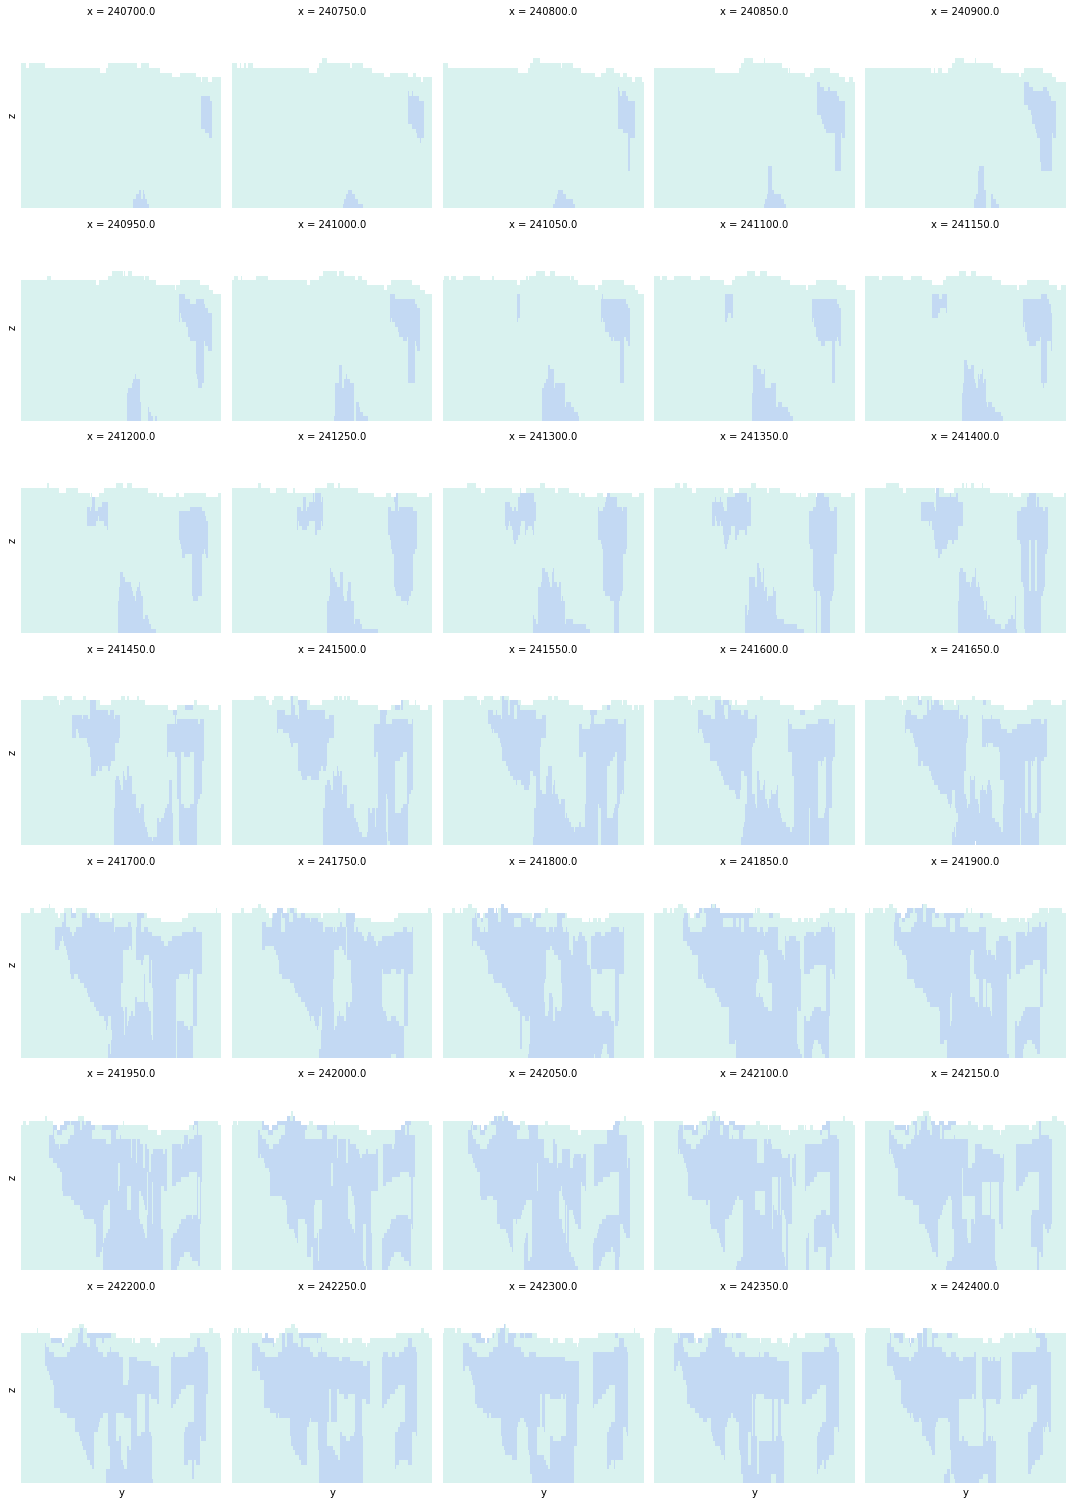

In [49]:
def draw_heatmap_x(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df1, col='x',col_wrap=5)
fg.map_dataframe(draw_heatmap_x, 'y', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r', cbar=False)
fg.tight_layout()

In [50]:
df1 = df[df['x'].between(x_min + N*x_step, x_min + (2*N-1)*x_step)]

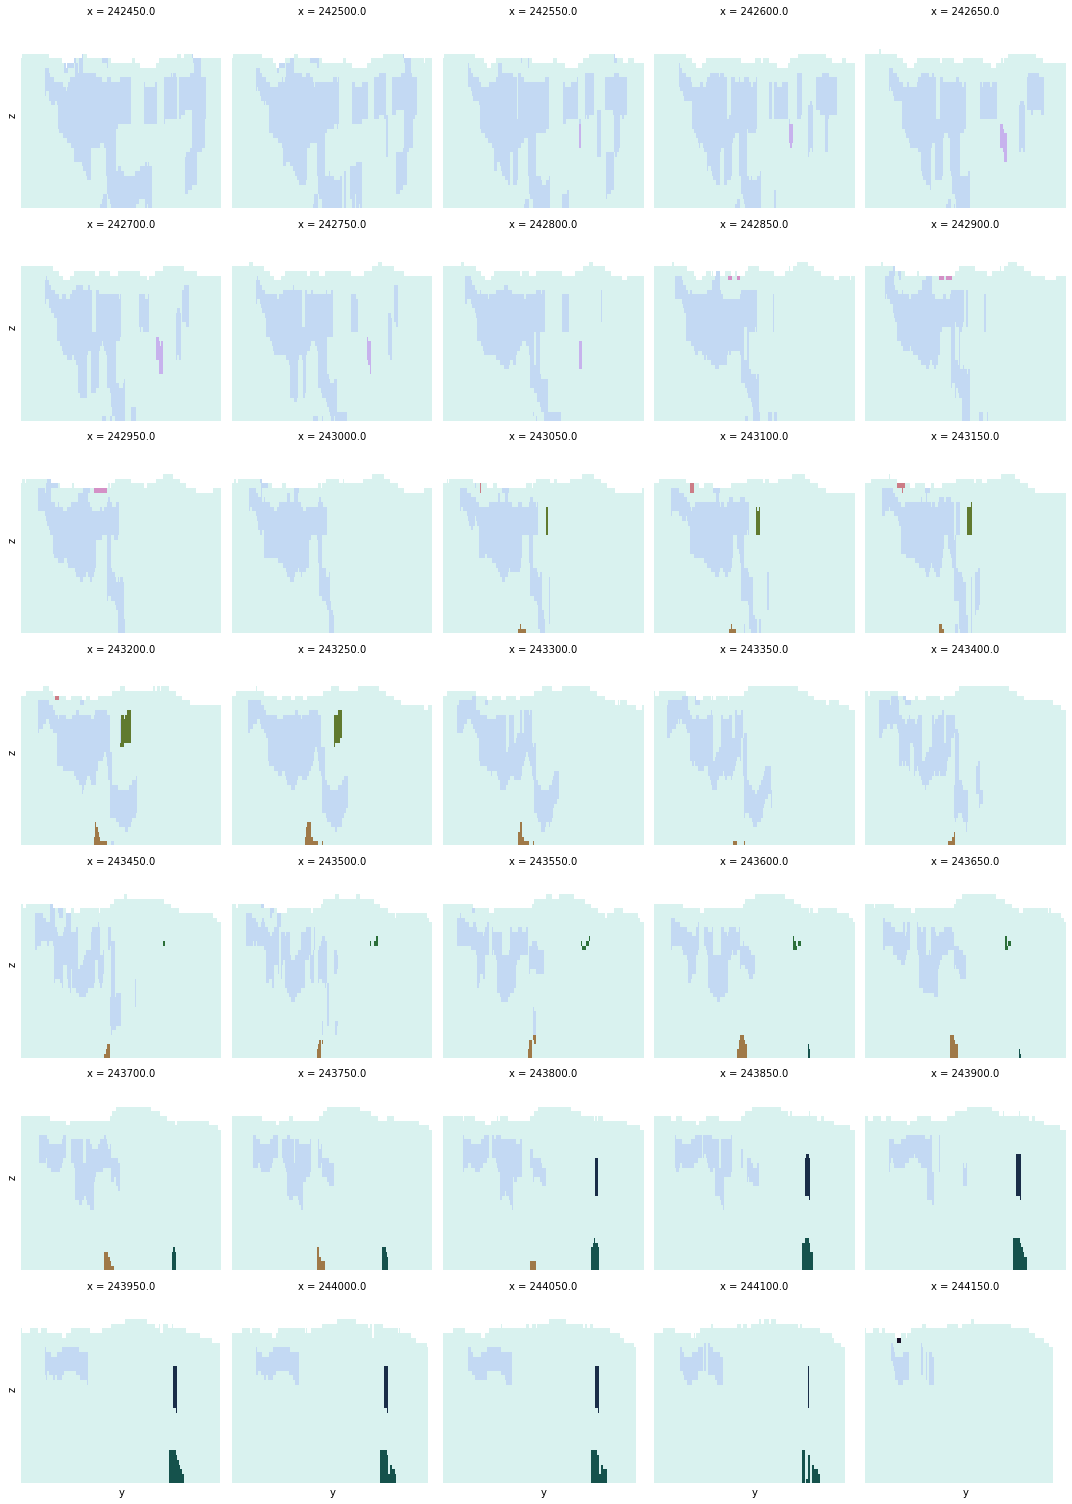

In [51]:
def draw_heatmap_x(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df1, col='x',col_wrap=5)
fg.map_dataframe(draw_heatmap_x, 'y', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r', cbar=False)
fg.tight_layout()

In [52]:
df1 = df[df['x']>=x_min + 2*N*x_step]

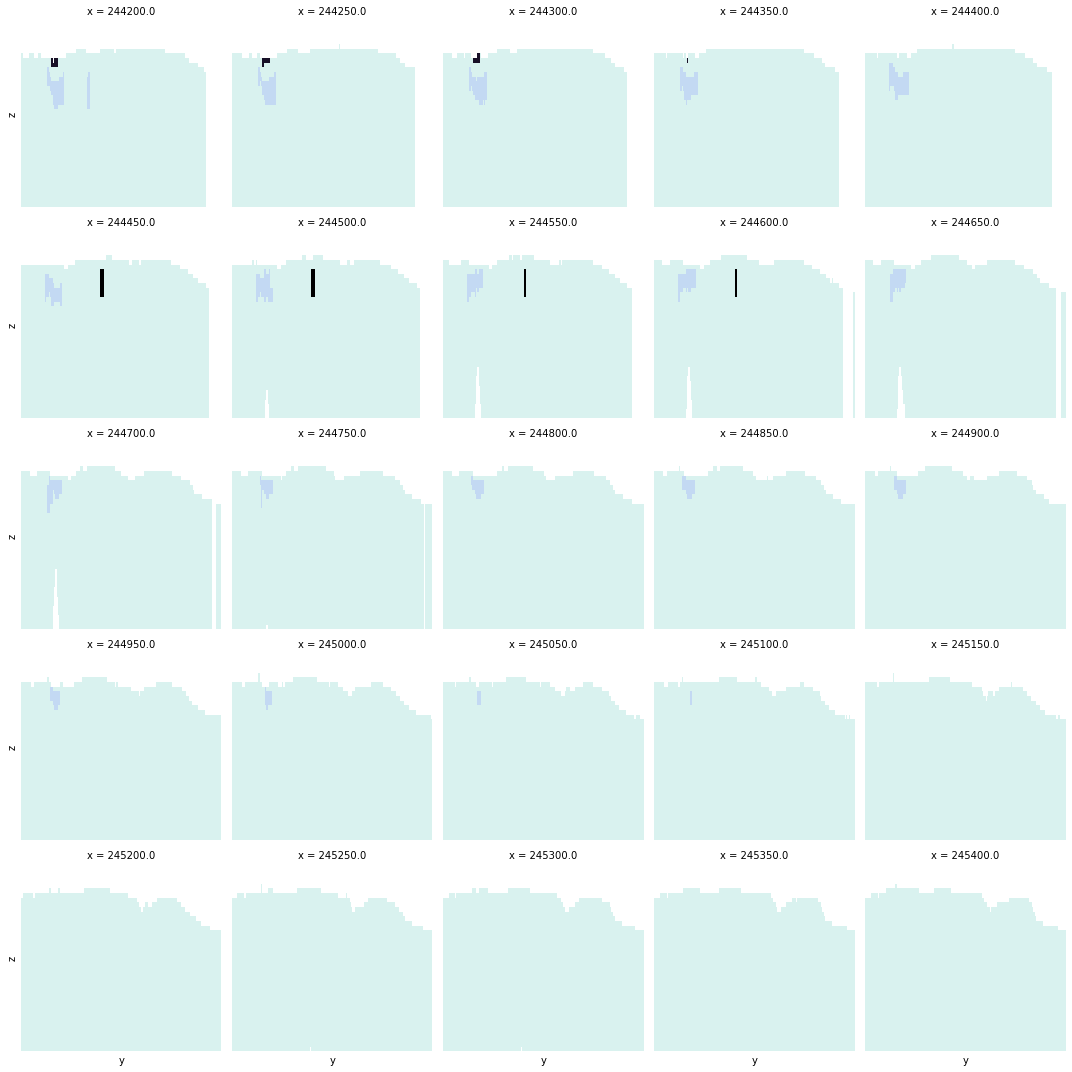

In [53]:
def draw_heatmap_x(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df1, col='x',col_wrap=5)
fg.map_dataframe(draw_heatmap_x, 'y', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r', cbar=False)
fg.tight_layout()

In [54]:
df2 = df[df['y'].between(y_min, y_min + (N-1)*y_step)]

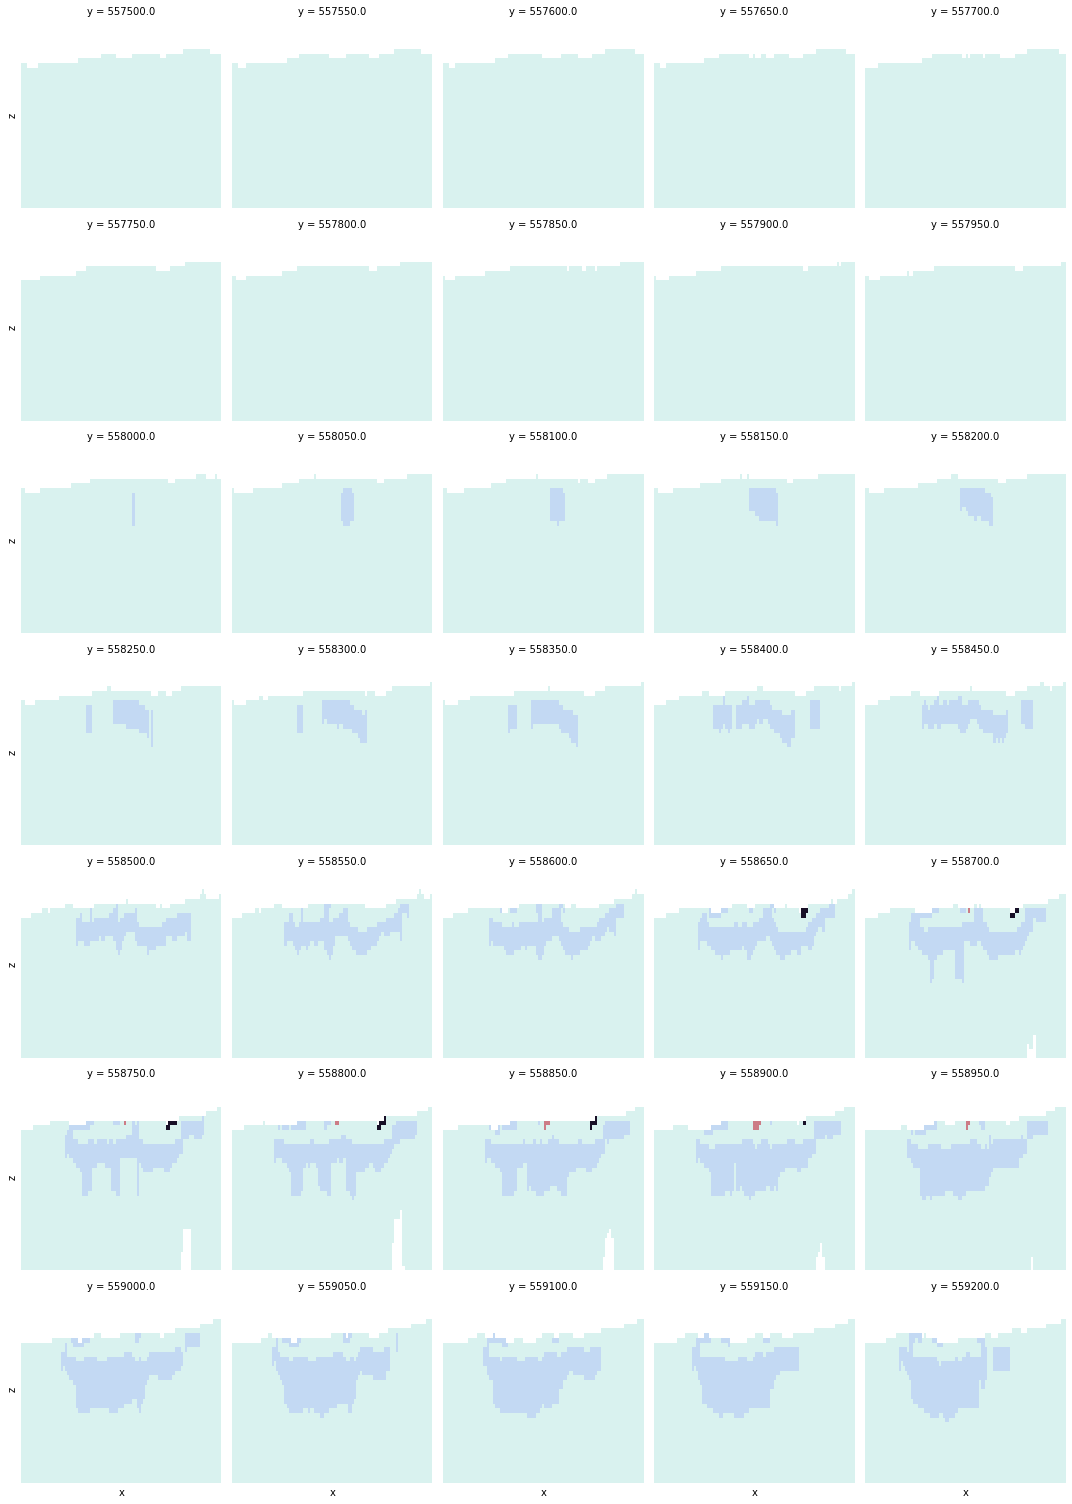

In [55]:
def draw_heatmap_y(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, cbar=False, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df2, col='y',col_wrap=5)
fg.map_dataframe(draw_heatmap_y, 'x', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r')
fg.tight_layout()

In [56]:
df2 = df[df['y'].between(y_min + N*y_step, y_min + (2*N-1)*y_step)]

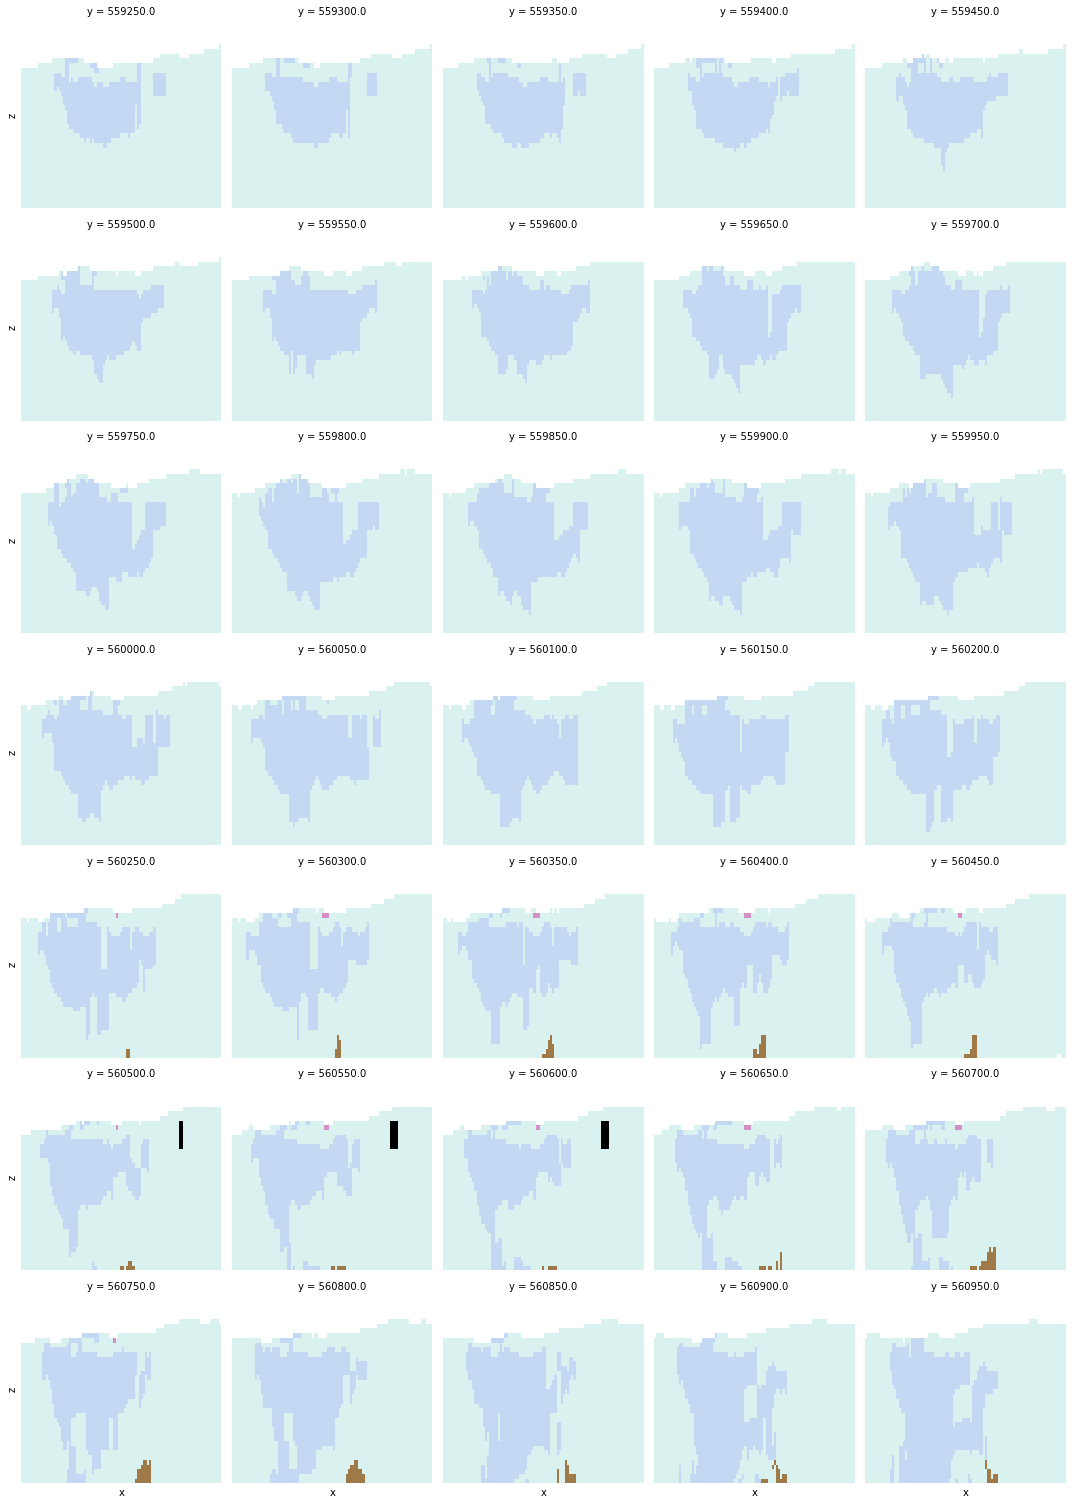

In [57]:
def draw_heatmap_y(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, cbar=False, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df2, col='y',col_wrap=5)
fg.map_dataframe(draw_heatmap_y, 'x', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r')
fg.tight_layout()

In [58]:
df2 = df[df['y'].between(y_min + 2*N*y_step, y_min + (3*N-1)*y_step)]

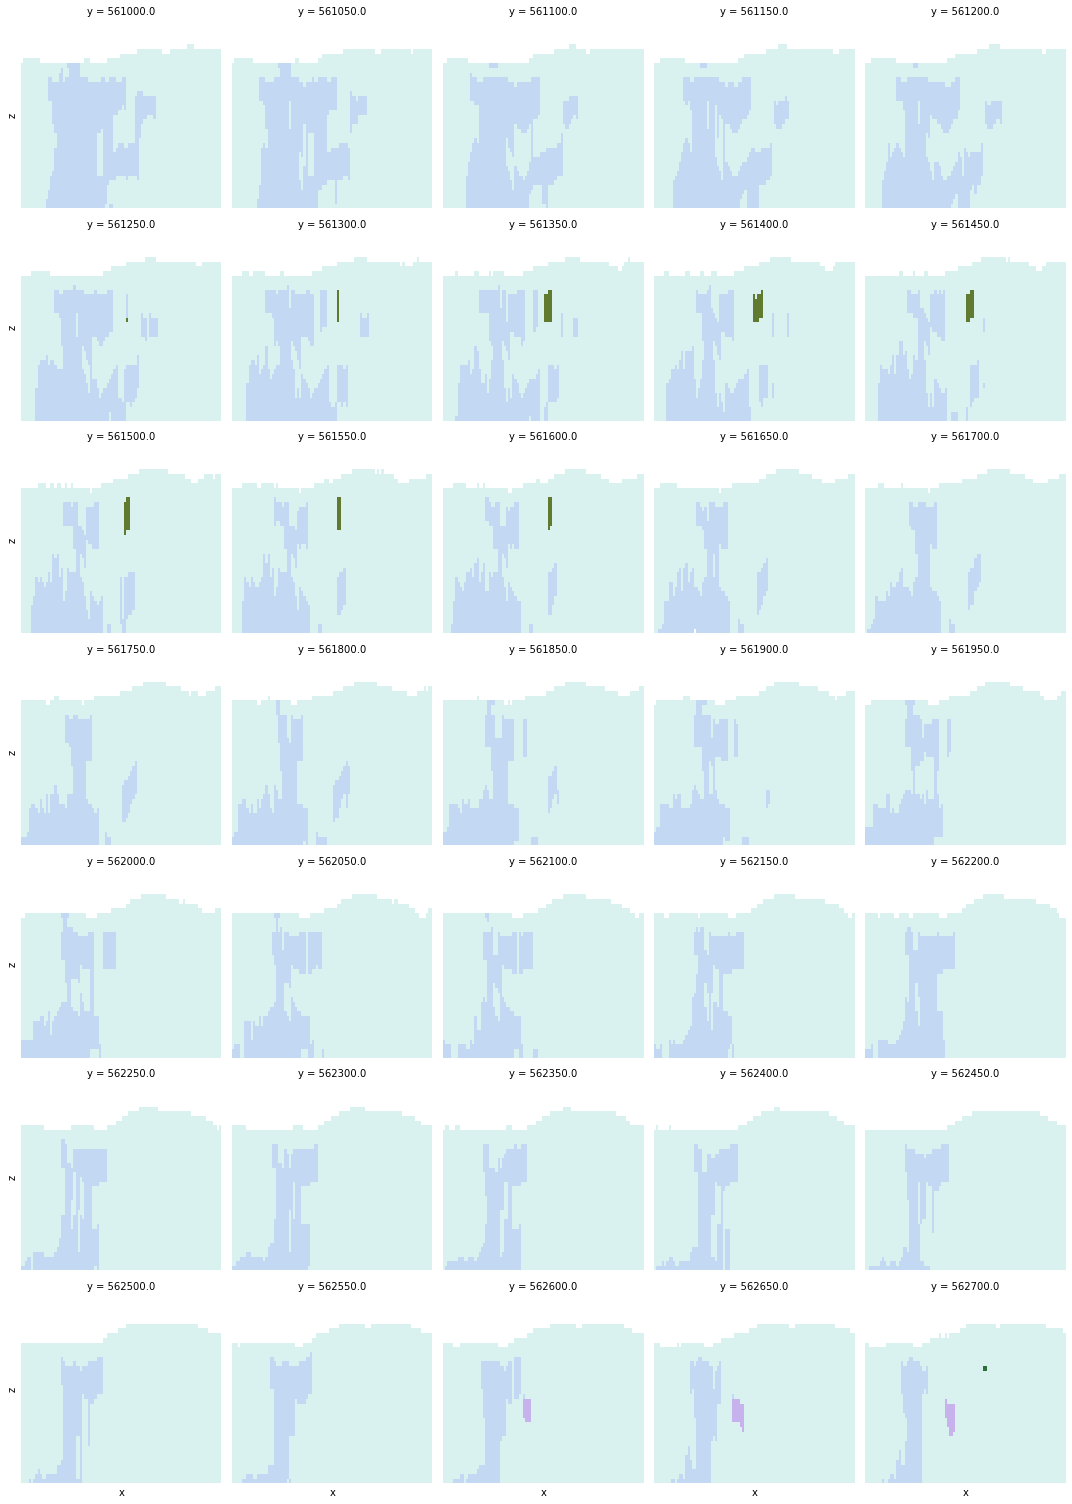

In [59]:
def draw_heatmap_y(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, cbar=False, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df2, col='y',col_wrap=5)
fg.map_dataframe(draw_heatmap_y, 'x', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r')
fg.tight_layout()

In [60]:
df2 = df[df['y'].between(y_min + 3*N*y_step, y_min + (4*N-1)*y_step)]

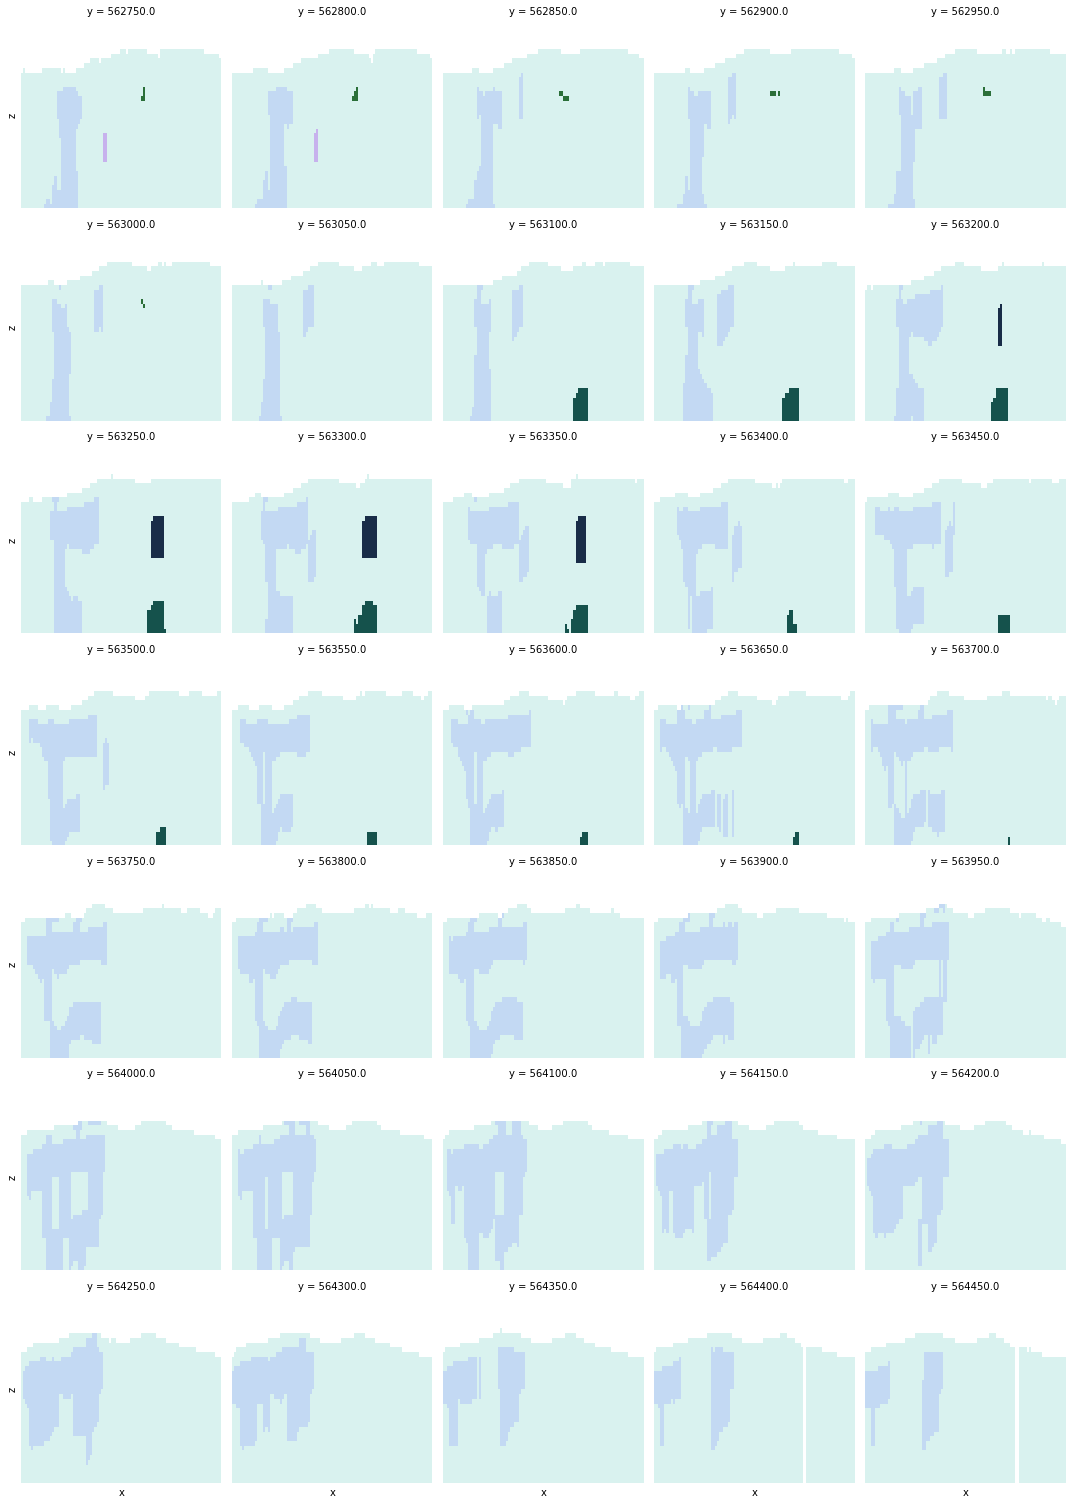

In [61]:
def draw_heatmap_y(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, cbar=False, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df2, col='y',col_wrap=5)
fg.map_dataframe(draw_heatmap_y, 'x', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r')
fg.tight_layout()

In [62]:
df2 = df[df['y']>=y_min + 4*N*y_step]

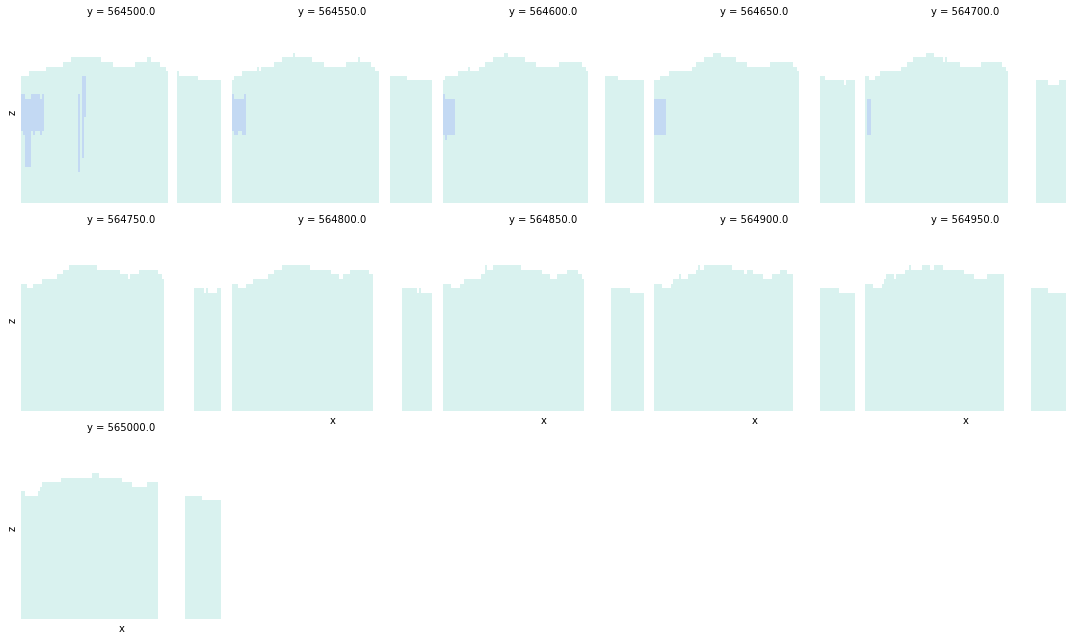

In [63]:
def draw_heatmap_y(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    ax = sns.heatmap(d, cbar=False, **kwargs)
    ax.invert_yaxis()

fg = sns.FacetGrid(df2, col='y',col_wrap=5)
fg.map_dataframe(draw_heatmap_y, 'x', 'z', 'cluster', vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False, cmap='cubehelix_r')
fg.tight_layout()